In [ ]:
import yfinance as yf
import pandas as pd
from tabulate import tabulate
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ta.momentum import RSIIndicator
from ta.trend import MACD
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
import os
import warnings
warnings.filterwarnings("ignore")

In [17]:
symbols = ["RELIANCE.NS", "HDFCBANK.NS", "INFY.NS"]

In [18]:
for symbol in symbols:   
    stock = yf.Ticker(symbol)
    info = stock.info
    print(f"Symbol: {symbol}")
    print(f"Name: {info.get('shortName', 'N/A')}")
    print(f"Market: {info.get('market', 'N/A')}")
    print(f"Sector: {info.get('sector', 'N/A')}")
    print("-" * 30)

Symbol: RELIANCE.NS
Name: RELIANCE INDUSTRIES LTD
Market: in_market
Sector: Energy
------------------------------
Symbol: HDFCBANK.NS
Name: HDFC BANK LTD
Market: in_market
Sector: Financial Services
------------------------------
Symbol: INFY.NS
Name: INFOSYS LIMITED
Market: in_market
Sector: Technology
------------------------------


# DATA VISUALISATION


Historical Data for HDFCBANK.NS for the last 6 months:
+---------------------------+----------+----------+----------+----------+-------------+-------------+----------------+
| Date                      |     Open |     High |      Low |    Close |      Volume |   Dividends |   Stock Splits |
|---------------------------+----------+----------+----------+----------+-------------+-------------+----------------|
| 2020-08-03 00:00:00+05:30 |  974.173 |  975.123 |  942.886 |  951.432 | 1.58918e+07 |           0 |              0 |
| 2020-08-04 00:00:00+05:30 |  957.129 | 1007.5   |  952.381 |  989.081 | 3.01531e+07 |           0 |              0 |
| 2020-08-05 00:00:00+05:30 |  995.063 | 1002.52  |  968.523 |  975.692 | 1.66107e+07 |           0 |              0 |
| 2020-08-06 00:00:00+05:30 |  984.665 | 1001.76  |  974.458 |  988.179 | 1.68234e+07 |           0 |              0 |
| 2020-08-07 00:00:00+05:30 |  982.624 |  994.351 |  969.093 |  991.17  | 1.24184e+07 |           0 |           

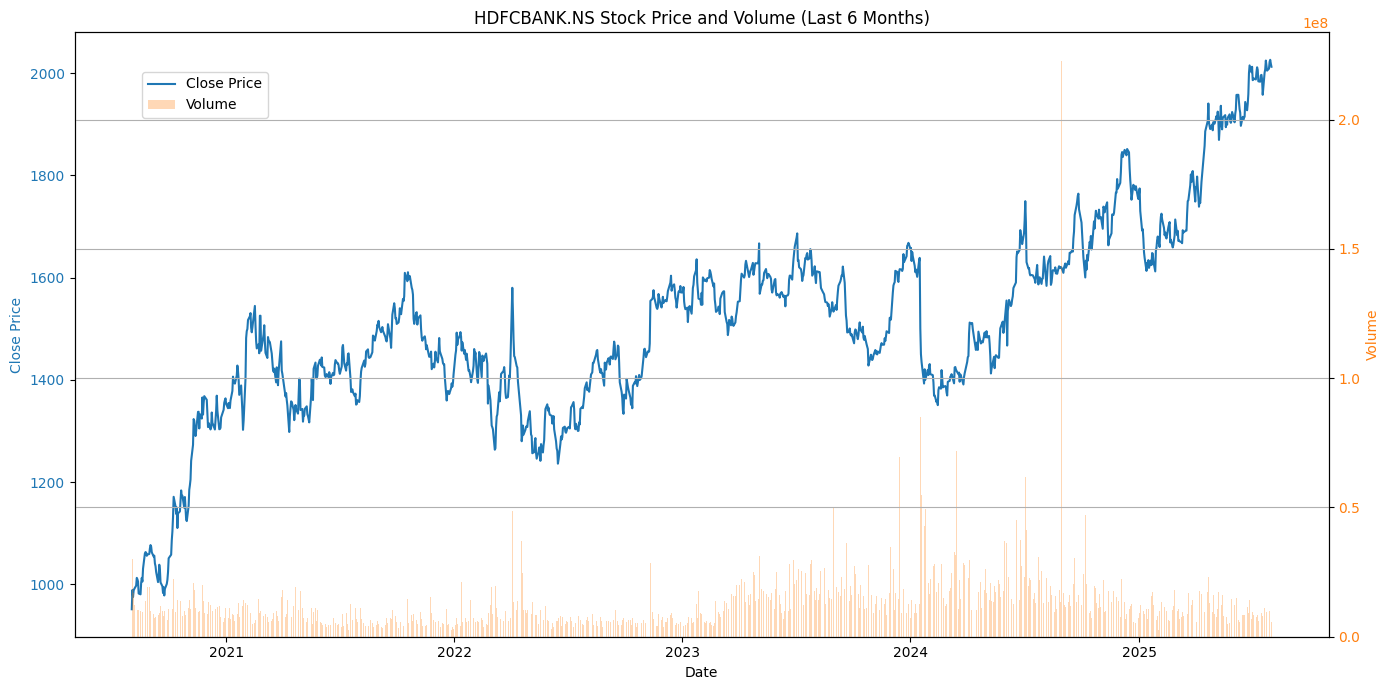

In [61]:
#we will fetch data for the last 6 months for each stock and plot the close price and volume
symbol = 'HDFCBANK.NS'
period = '5y'  

stock = yf.Ticker(symbol)
data = stock.history(period=period)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print(f"Historical Data for {symbol} for the last 6 months:")
formatted_data = pd.concat([data.head(), data.tail()])
print(tabulate(formatted_data, headers='keys', tablefmt='psql'))


# Plotting the data
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='tab:blue')
ax1.plot(data.index, data['Close'], color='tab:blue', label='Close Price')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Volume', color='tab:orange')
ax2.bar(data.index, data['Volume'], color='tab:orange', alpha=0.3, label='Volume')
ax2.tick_params(axis='y', labelcolor='tab:orange')


plt.title(f'{symbol} Stock Price and Volume (Last 6 Months)')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.grid(True)
plt.show()

Historical Data for RELIANCE.NS for the last 6 months:
+---------------------------+----------+----------+----------+----------+-------------+-------------+----------------+
| Date                      |     Open |     High |      Low |    Close |      Volume |   Dividends |   Stock Splits |
|---------------------------+----------+----------+----------+----------+-------------+-------------+----------------|
| 2020-08-03 00:00:00+05:30 |  933.838 |  936.433 |  911.896 |  914.582 | 4.67154e+07 |           0 |              0 |
| 2020-08-04 00:00:00+05:30 |  919.862 |  986.51  |  910.598 |  979.044 | 9.20411e+07 |           0 |              0 |
| 2020-08-05 00:00:00+05:30 |  987.42  |  999.712 |  964.34  |  968.05  | 7.455e+07   |           0 |              0 |
| 2020-08-06 00:00:00+05:30 |  981.957 |  986.829 |  959.56  |  971.532 | 4.9323e+07  |           0 |              0 |
| 2020-08-07 00:00:00+05:30 |  969.575 |  982.322 |  965.205 |  977.155 | 3.29844e+07 |           0 |           

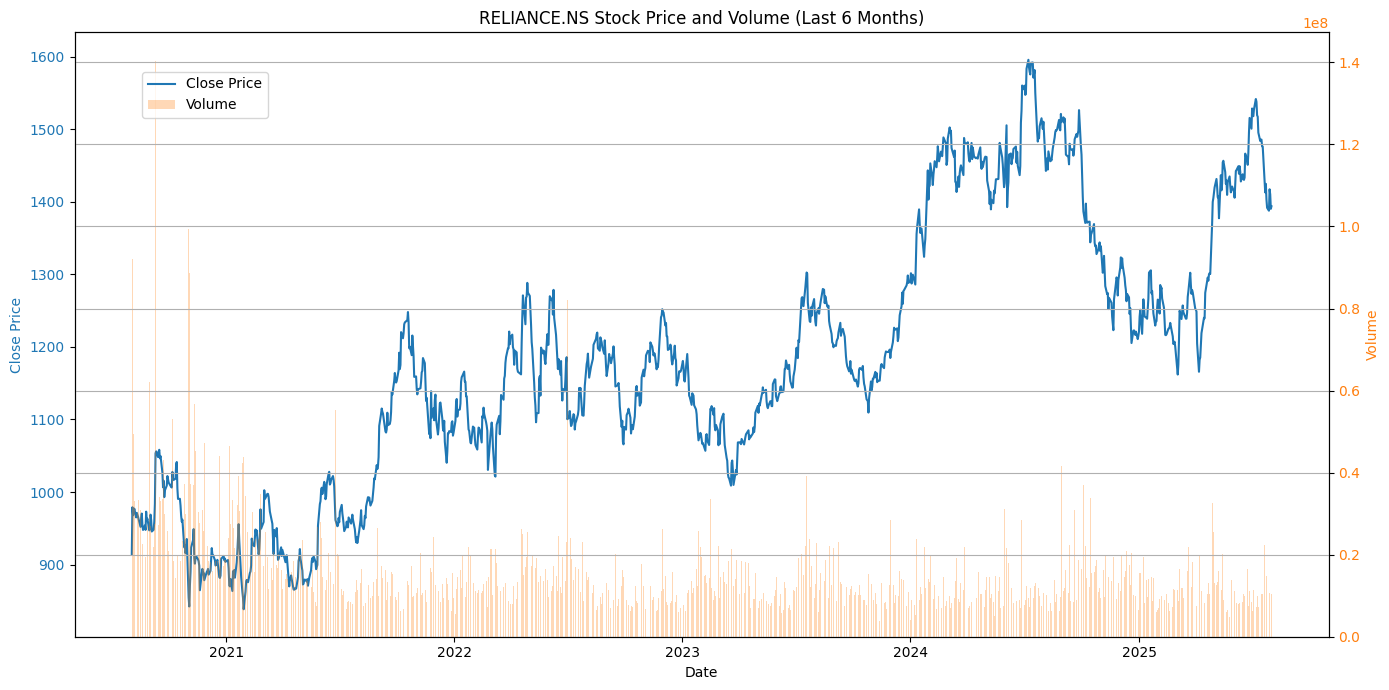

In [62]:
#we will fetch data for the last 6 months for each stock and plot the close price and volume
symbol = 'RELIANCE.NS'
period = '5y'  

stock = yf.Ticker(symbol)
data = stock.history(period=period)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print(f"Historical Data for {symbol} for the last 6 months:")
formatted_data = pd.concat([data.head(), data.tail()])
print(tabulate(formatted_data, headers='keys', tablefmt='psql'))


# Plotting the data
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='tab:blue')
ax1.plot(data.index, data['Close'], color='tab:blue', label='Close Price')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Volume', color='tab:orange')
ax2.bar(data.index, data['Volume'], color='tab:orange', alpha=0.3, label='Volume')
ax2.tick_params(axis='y', labelcolor='tab:orange')


plt.title(f'{symbol} Stock Price and Volume (Last 6 Months)')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.grid(True)
plt.show()

Historical Data for INFY.NS for the last 6 months:
+---------------------------+----------+----------+----------+----------+-------------+-------------+----------------+
| Date                      |     Open |     High |      Low |    Close |      Volume |   Dividends |   Stock Splits |
|---------------------------+----------+----------+----------+----------+-------------+-------------+----------------|
| 2020-08-03 00:00:00+05:30 |  853.778 |  858.581 |  842.617 |  851.021 | 8.47979e+06 |           0 |              0 |
| 2020-08-04 00:00:00+05:30 |  854.179 |  863.294 |  836.48  |  844.751 | 1.11332e+07 |           0 |              0 |
| 2020-08-05 00:00:00+05:30 |  846.663 |  854.623 |  834.479 |  840.171 | 9.61418e+06 |           0 |              0 |
| 2020-08-06 00:00:00+05:30 |  847.998 |  866.585 |  838.215 |  863.428 | 1.09765e+07 |           0 |              0 |
| 2020-08-07 00:00:00+05:30 |  862.183 |  862.183 |  843.996 |  845.685 | 8.01095e+06 |           0 |              0

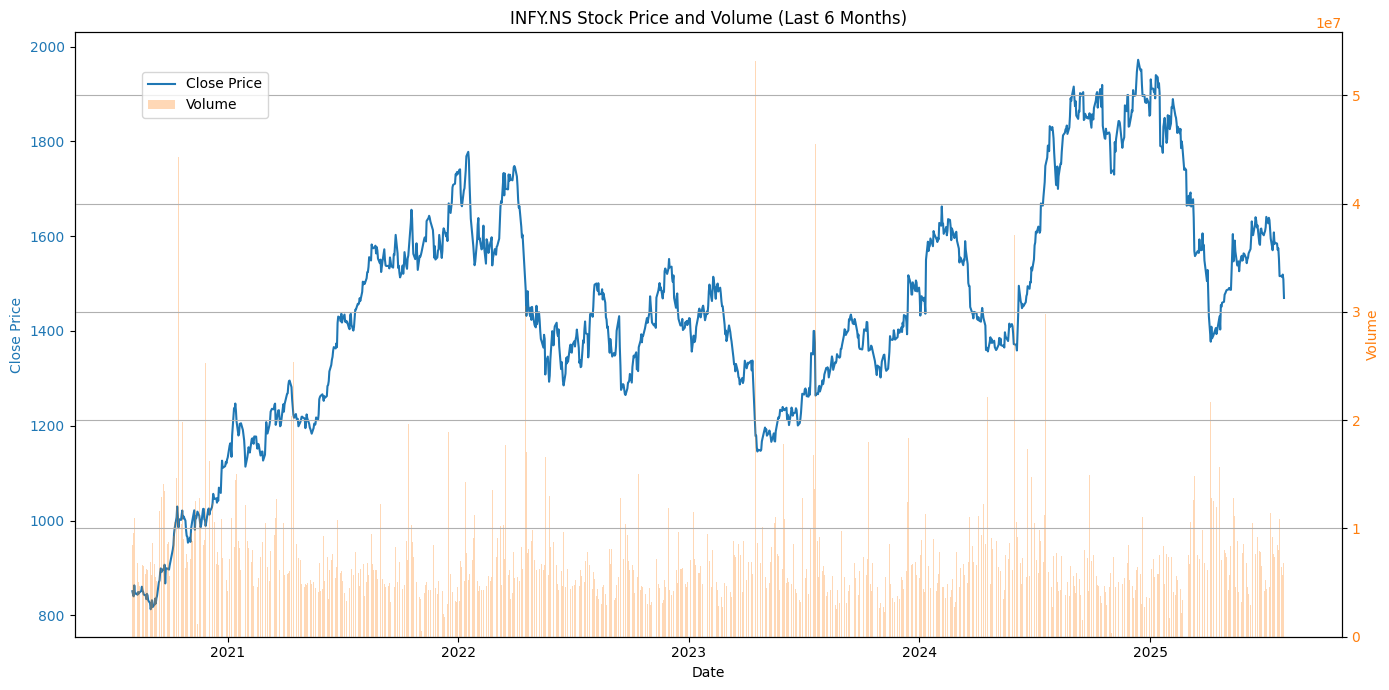

In [63]:
#we will fetch data for the last 6 months for each stock and plot the close price and volume
symbol = 'INFY.NS'
period = '5y'  

stock = yf.Ticker(symbol)
data = stock.history(period=period)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print(f"Historical Data for {symbol} for the last 6 months:")
formatted_data = pd.concat([data.head(), data.tail()])
print(tabulate(formatted_data, headers='keys', tablefmt='psql'))


# Plotting the data
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='tab:blue')
ax1.plot(data.index, data['Close'], color='tab:blue', label='Close Price')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Volume', color='tab:orange')
ax2.bar(data.index, data['Volume'], color='tab:orange', alpha=0.3, label='Volume')
ax2.tick_params(axis='y', labelcolor='tab:orange')


plt.title(f'{symbol} Stock Price and Volume (Last 6 Months)')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.grid(True)
plt.show()

# PREPROCESSING THE DATA

In [78]:
from ta.momentum import RSIIndicator
from ta.trend import MACD
import pandas as pd

def preprocess_stock(df):
    df = df.copy()

    # --- Technical Indicators ---
    df["RSI"] = RSIIndicator(df["Close"], window=14).rsi()
    df["MACD"] = MACD(df["Close"]).macd()
    df["MACD_Signal"] = MACD(df["Close"]).macd_signal()
    df["SMA_20"] = df["Close"].rolling(window=20).mean()
    df["SMA_50"] = df["Close"].rolling(window=50).mean()
    df["EMA_20"] = df["Close"].ewm(span=20, adjust=False).mean()
    df["Volatility"] = df["Close"].rolling(window=10).std()
    df["Volume"] = df["Volume"]

    # --- Strategy Logic ---
    df["Buy_Signal"] = (
        (df["RSI"] < 30) &
        (df["SMA_20"] > df["SMA_50"]) &
        (df["SMA_20"].shift(1) <= df["SMA_50"].shift(1))
    ).astype(int)

    # --- Target for ML ---
    df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)

    return df.dropna()

In [ ]:
symbol_infy = 'INFY.NS'
print(f"Preprocessed data for {symbol_infy}")
data_infy = yf.Ticker(symbol_infy).history(period='5y')
processed_infy = preprocess_stock(data_infy)
processed_infy.head()

Preprocessed data for INFY.NS


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Target,RSI,MACD,MACD_Signal,SMA_20,EMA_20,Volatility
Date,,,,,,,,,,,,,,
2020-09-17 00:00:00+05:30,884.905676,908.028839,884.905676,899.135315,15628241,0.0,0.0,0,71.099330,9.010944,0.290296,842.230103,851.370525,29.736039
2020-09-18 00:00:00+05:30,899.135335,906.072273,888.552019,891.264587,12897633,0.0,0.0,1,66.667778,10.966000,2.425437,844.602454,855.169959,29.598365
2020-09-21 00:00:00+05:30,890.241725,916.922296,889.797048,898.156982,14140637,0.0,0.0,0,68.518277,12.922591,4.524868,847.381677,859.263962,29.057425
2020-09-22 00:00:00+05:30,897.356612,909.362870,881.526149,896.022583,12625762,0.0,0.0,1,67.272748,14.138001,6.447495,850.467731,862.764783,28.251069
2020-09-23 00:00:00+05:30,907.272877,922.258443,896.556137,906.917114,13486204,0.0,0.0,0,70.245867,15.798208,8.317637,853.533771,866.969767,24.736995


In [ ]:
symbol_reliance = 'RELIANCE.NS'
print(f"Preprocessed data for {symbol_reliance}")
data_reliance = yf.Ticker(symbol_reliance).history(period='2y')
processed_reliance = preprocess_stock(data_reliance)
processed_reliance.head()

Preprocessed data for RELIANCE.NS


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Target,RSI,MACD,MACD_Signal,SMA_20,EMA_20,Volatility
Date,,,,,,,,,,,,,,
2020-09-17 00:00:00+05:30,1056.161949,1062.398851,1043.346890,1046.488159,25828669,0.0,0.0,1,68.333119,27.637777,18.479457,986.482593,1000.479253,49.589680
2020-09-18 00:00:00+05:30,1053.544276,1055.911517,1036.381629,1049.651978,33074915,0.0,0.0,0,68.967771,28.055863,20.394738,991.577890,1005.162370,43.891639
2020-09-21 00:00:00+05:30,1047.057102,1063.445842,1023.088591,1026.958252,33627381,0.0,0.0,0,59.721985,26.253372,21.566465,995.222107,1007.238168,34.426241
2020-09-22 00:00:00+05:30,1036.586471,1036.586471,1002.238479,1006.608826,34792254,0.0,0.0,1,52.876679,22.918664,21.836905,998.159561,1007.178231,24.997529
2020-09-23 00:00:00+05:30,1028.847367,1036.472654,1003.945641,1015.554260,42988708,0.0,0.0,0,55.302061,20.758416,21.621207,1000.287817,1007.975948,18.475367


In [66]:
symbol_hdfc = 'HDFCBANK.NS'
print(f"Preprocessed data for {symbol_hdfc}")
data_hdfc = yf.Ticker(symbol_hdfc).history(period='5y')
processed_hdfc = preprocess_stock(data_hdfc)
processed_hdfc.head()

Preprocessed data for HDFCBANK.NS


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Target,RSI,MACD,MACD_Signal,SMA_20,EMA_20,Volatility
Date,,,,,,,,,,,,,,
2020-09-17 00:00:00+05:30,1029.293533,1038.788860,1023.596336,1028.913696,9159343,0.0,0.0,0,50.002480,5.434087,12.145571,1048.725674,1033.721314,18.448122
2020-09-18 00:00:00+05:30,1036.889781,1037.079641,994.350666,1003.941040,11740889,0.0,0.0,0,41.916484,2.545320,10.225520,1047.379721,1030.885097,18.436295
2020-09-21 00:00:00+05:30,1001.756955,1017.281791,988.938264,996.344666,9921439,0.0,0.0,0,39.807685,-0.352945,8.109827,1044.163177,1027.595532,19.155527
2020-09-22 00:00:00+05:30,1000.854987,1004.748048,977.543913,983.146179,9310339,0.0,0.0,1,36.382779,-3.672513,5.753359,1040.160898,1023.362260,19.659653
2020-09-23 00:00:00+05:30,993.211216,1001.757011,982.149137,994.398132,8039914,0.0,0.0,0,41.040009,-5.333871,3.535913,1036.780560,1020.603772,18.892412


# VISUALISE THE PREPROCESSED DATA

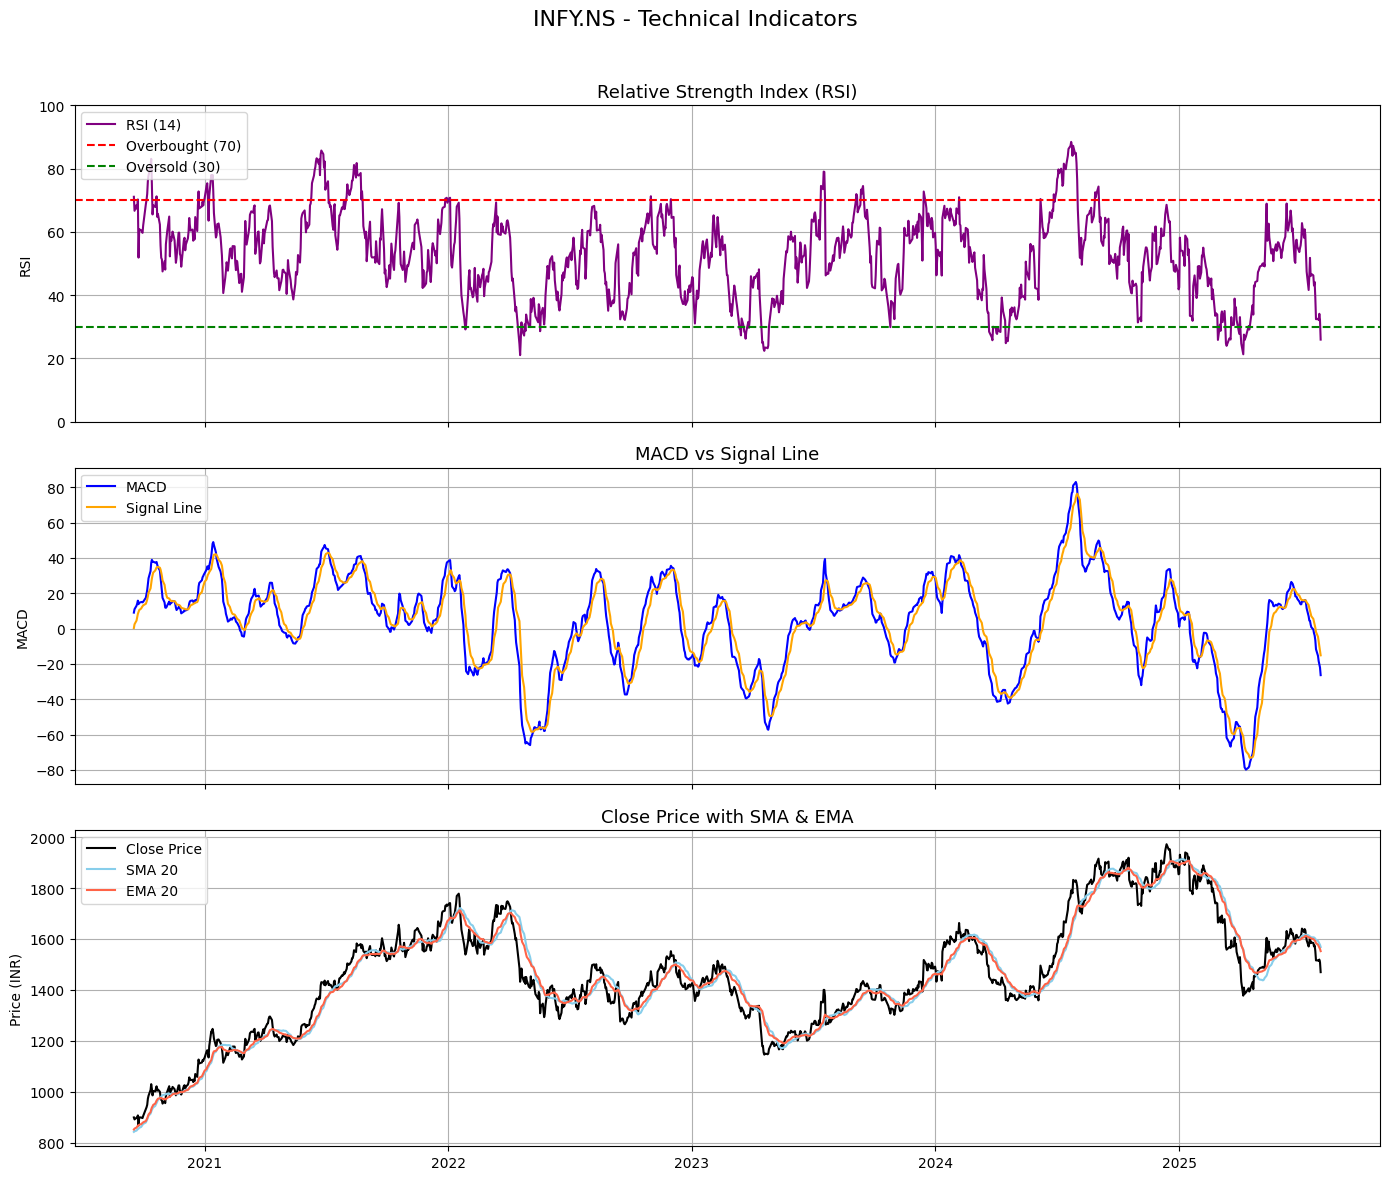

In [67]:
symbol = 'INFY.NS' 
data = processed_infy 

fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
fig.suptitle(f'{symbol} - Technical Indicators', fontsize=16)

# RSI
axes[0].plot(data.index, data['RSI'], label='RSI (14)', color='purple')
axes[0].axhline(70, color='red', linestyle='--', label='Overbought (70)')
axes[0].axhline(30, color='green', linestyle='--', label='Oversold (30)')
axes[0].set_ylim(0, 100)
axes[0].set_ylabel('RSI')
axes[0].set_title('Relative Strength Index (RSI)', fontsize=13)
axes[0].legend(loc='upper left')
axes[0].grid(True)

# MACD
axes[1].plot(data.index, data['MACD'], label='MACD', color='blue')
axes[1].plot(data.index, data['MACD_Signal'], label='Signal Line', color='orange')
axes[1].set_ylabel('MACD')
axes[1].set_title('MACD vs Signal Line', fontsize=13)
axes[1].legend(loc='upper left')
axes[1].grid(True)

# Close + SMA + EMA
axes[2].plot(data.index, data['Close'], label='Close Price', color='black')
axes[2].plot(data.index, data['SMA_20'], label='SMA 20', color='skyblue')
axes[2].plot(data.index, data['EMA_20'], label='EMA 20', color='tomato')
axes[2].set_ylabel('Price (INR)')
axes[2].set_title('Close Price with SMA & EMA', fontsize=13)
axes[2].legend(loc='upper left')
axes[2].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

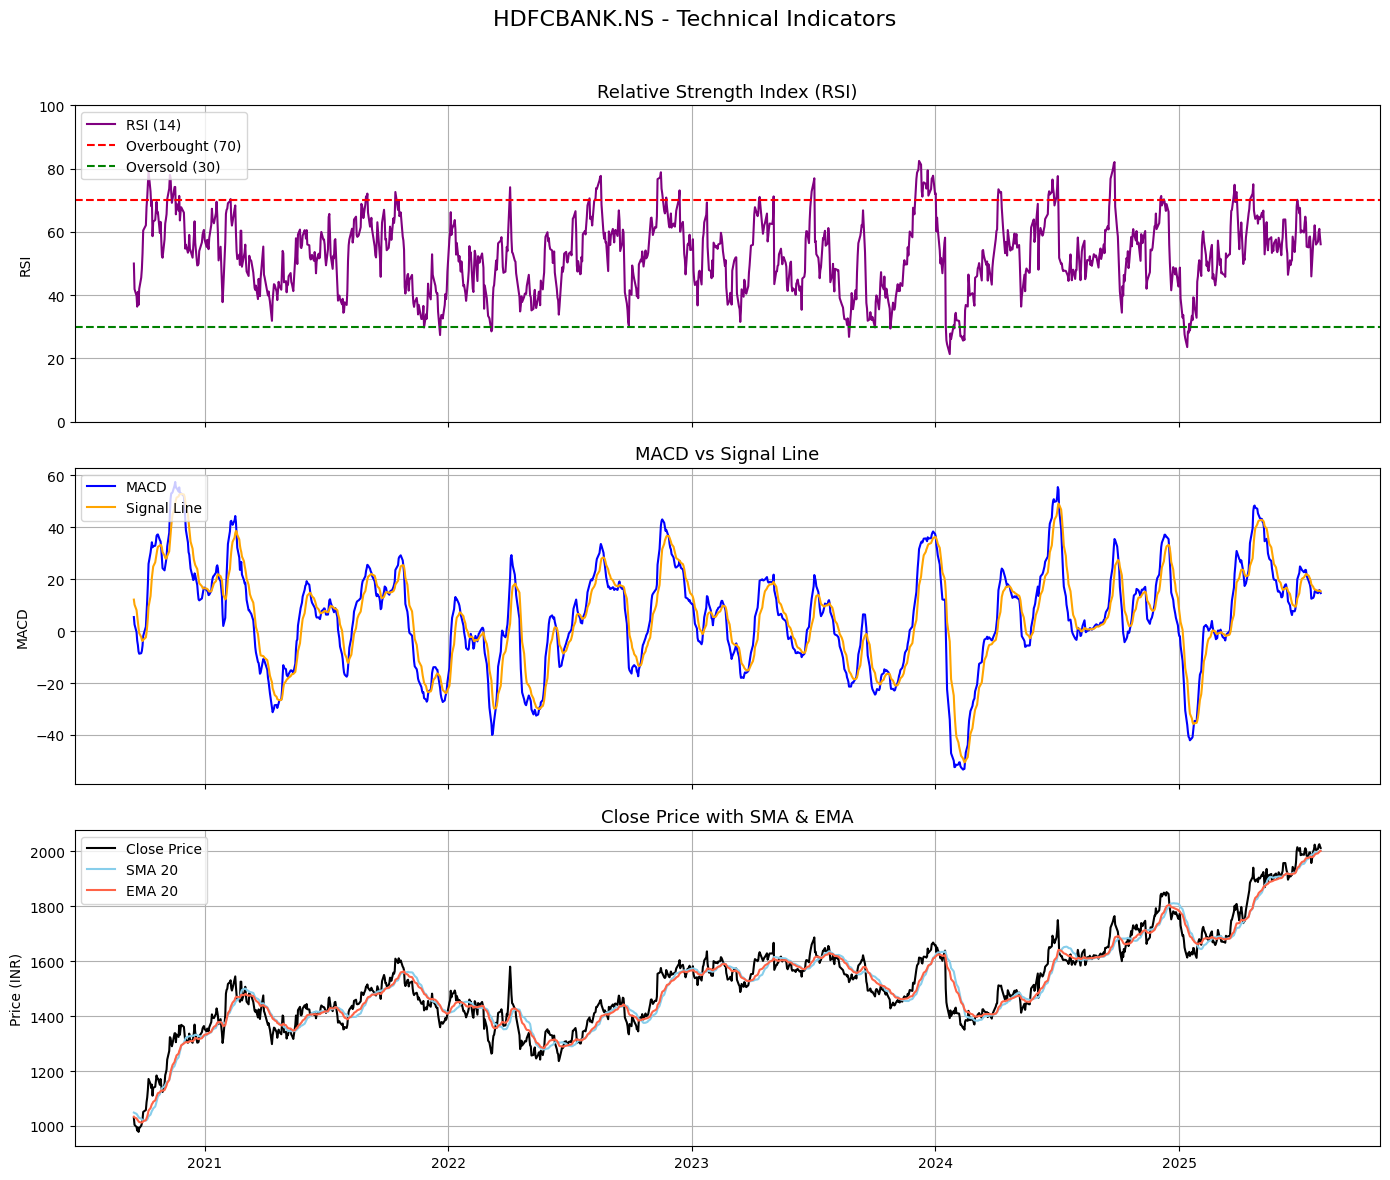

In [68]:
symbol = 'HDFCBANK.NS'
data = processed_hdfc  # Make sure this is defined from preprocessing

fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
fig.suptitle(f'{symbol} - Technical Indicators', fontsize=16)

# RSI
axes[0].plot(data.index, data['RSI'], label='RSI (14)', color='purple')
axes[0].axhline(70, color='red', linestyle='--', label='Overbought (70)')
axes[0].axhline(30, color='green', linestyle='--', label='Oversold (30)')
axes[0].set_ylim(0, 100)
axes[0].set_ylabel('RSI')
axes[0].set_title('Relative Strength Index (RSI)', fontsize=13)
axes[0].legend(loc='upper left')
axes[0].grid(True)

# MACD
axes[1].plot(data.index, data['MACD'], label='MACD', color='blue')
axes[1].plot(data.index, data['MACD_Signal'], label='Signal Line', color='orange')
axes[1].set_ylabel('MACD')
axes[1].set_title('MACD vs Signal Line', fontsize=13)
axes[1].legend(loc='upper left')
axes[1].grid(True)

# Close + SMA + EMA
axes[2].plot(data.index, data['Close'], label='Close Price', color='black')
axes[2].plot(data.index, data['SMA_20'], label='SMA 20', color='skyblue')
axes[2].plot(data.index, data['EMA_20'], label='EMA 20', color='tomato')
axes[2].set_ylabel('Price (INR)')
axes[2].set_title('Close Price with SMA & EMA', fontsize=13)
axes[2].legend(loc='upper left')
axes[2].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

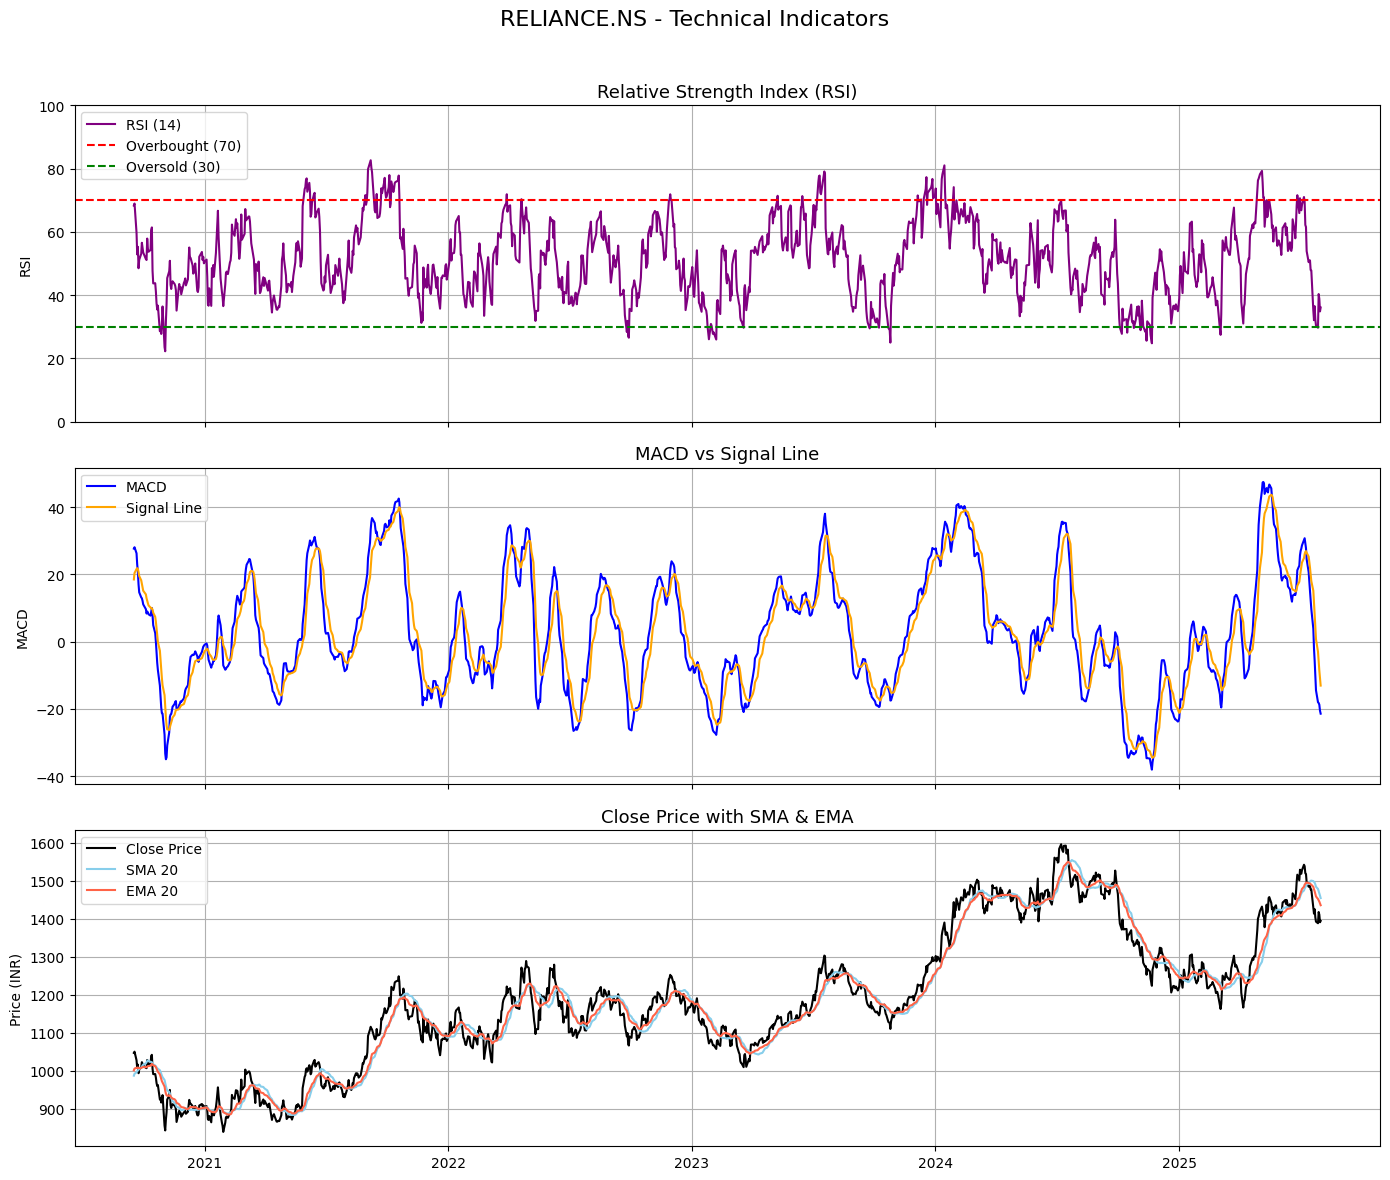

In [69]:
symbol = 'RELIANCE.NS'
data = processed_reliance  # Again, this should be defined already

fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
fig.suptitle(f'{symbol} - Technical Indicators', fontsize=16)

# RSI
axes[0].plot(data.index, data['RSI'], label='RSI (14)', color='purple')
axes[0].axhline(70, color='red', linestyle='--', label='Overbought (70)')
axes[0].axhline(30, color='green', linestyle='--', label='Oversold (30)')
axes[0].set_ylim(0, 100)
axes[0].set_ylabel('RSI')
axes[0].set_title('Relative Strength Index (RSI)', fontsize=13)
axes[0].legend(loc='upper left')
axes[0].grid(True)

# MACD
axes[1].plot(data.index, data['MACD'], label='MACD', color='blue')
axes[1].plot(data.index, data['MACD_Signal'], label='Signal Line', color='orange')
axes[1].set_ylabel('MACD')
axes[1].set_title('MACD vs Signal Line', fontsize=13)
axes[1].legend(loc='upper left')
axes[1].grid(True)

# Close + SMA + EMA
axes[2].plot(data.index, data['Close'], label='Close Price', color='black')
axes[2].plot(data.index, data['SMA_20'], label='SMA 20', color='skyblue')
axes[2].plot(data.index, data['EMA_20'], label='EMA 20', color='tomato')
axes[2].set_ylabel('Price (INR)')
axes[2].set_title('Close Price with SMA & EMA', fontsize=13)
axes[2].legend(loc='upper left')
axes[2].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# MODEL TRAINING (only on INFY.NS)

In [75]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.1, 0.2],
}

# Use TimeSeriesSplit to maintain time order
tscv = TimeSeriesSplit(n_splits=5)

# Grid Search
grid = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=param_grid,
    scoring='precision',
    cv=tscv,
    verbose=1,
    n_jobs=-1
)

grid.fit(X, y)

# Best model
best_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

# Filter last 6 months from X and y using index
last_6mo = processed_infy.index >= (processed_infy.index.max() - pd.DateOffset(months=6))
X_backtest = X[last_6mo]
y_backtest = y[last_6mo]

y_pred = best_model.predict(X_backtest)

# Evaluation
from sklearn.metrics import accuracy_score, precision_score
print("✅ Accuracy:", round(accuracy_score(y_backtest, y_pred), 3))
print("✅ Precision:", round(precision_score(y_backtest, y_pred), 3))

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:22:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:22:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:22:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15

Best Parameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 150}
✅ Accuracy: 0.952
✅ Precision: 0.938


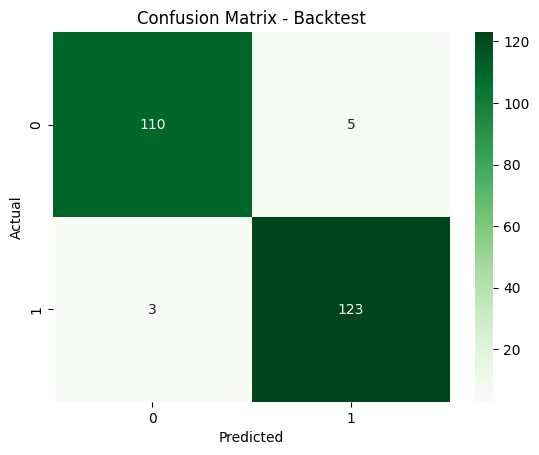

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       115
           1       0.96      0.98      0.97       126

    accuracy                           0.97       241
   macro avg       0.97      0.97      0.97       241
weighted avg       0.97      0.97      0.97       241



In [73]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_backtest, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Backtest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_backtest, y_pred))

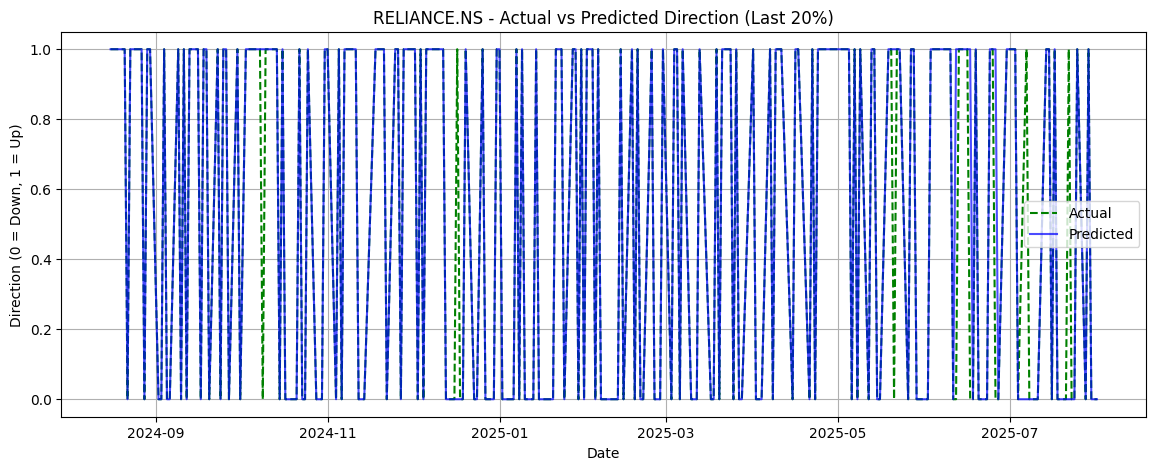

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(y_backtest.index, y_backtest.values, label='Actual', linestyle='--', color='green')
plt.plot(y_backtest.index, y_pred, label='Predicted', alpha=0.7, color='blue')

plt.title(f"{symbol} - Actual vs Predicted Direction (Last 20%)")
plt.xlabel("Date")
plt.ylabel("Direction (0 = Down, 1 = Up)")
plt.legend()
plt.grid(True)
plt.show()

In [77]:
importances = best_model.feature_importances_
features = X.columns
for feat, score in zip(features, importances):
    print(f"{feat}: {score:.3f}")

RSI: 0.164
MACD: 0.156
MACD_Signal: 0.171
SMA_20: 0.156
EMA_20: 0.190
Volatility: 0.163
